In [1]:
import math
import mediapipe as mp
import cv2
import numpy as np
import skatePoseModule as spm
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import random

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

psd = spm.poseDetector(min_detection_confidence=0.2, min_tracking_confidence=0.8, model_complexity=2)

In [253]:
# open video file
video_path = './kakao/103_2.mp4'
cap = cv2.VideoCapture(video_path)
fit_to = 'width'

# check file is opened
if not cap.isOpened():
    exit()
    
lmlist = []
rightLegAngleList = []
leftLegAngleList = []
rightGolbanAngleList = []
leftGolbanAngleList = []
visibility = []

In [254]:
# initialize tracker
OPENCV_OBJECT_TRACKERS = {
  "csrt": cv2.TrackerCSRT_create
}

tracker = OPENCV_OBJECT_TRACKERS['csrt']()

# global variables
top_bottom_list, left_right_list = [], []
count = 0

In [255]:
# main
ret, img = cap.read()

cv2.namedWindow('Select Window')
cv2.imshow('Select Window', img)

# select ROI
rect = cv2.selectROI('Select Window', img, fromCenter=False, showCrosshair=True)
cv2.destroyWindow('Select Window')
scale = 1.3

output_size = (int(rect[2]*scale), int(rect[3]*scale)) # (width, height)

# initialize tracker
tracker.init(img, rect)

with mp_pose.Pose(min_detection_confidence=0.3, min_tracking_confidence=0.7, model_complexity=0) as pose:
    while True:
        count += 1
        # read frame from video
        ret, img = cap.read()

        if not ret:
            break
        # update tracker and get position from new frame
        success, box = tracker.update(img)
        # if success:
        left, top, w, h = [int(v) for v in box]
        right = left + w
        bottom = top + h

        # save sizes of image
        top_bottom_list.append(np.array([top, bottom]))
        left_right_list.append(np.array([left, right]))

        # use recent 10 elements for crop (window_size=10)
        if len(top_bottom_list) > 10:
            del top_bottom_list[0]
            del left_right_list[0]

        # compute moving average
        avg_height_range = np.mean(top_bottom_list, axis=0).astype(int)
        avg_width_range = np.mean(left_right_list, axis=0).astype(int)
        avg_center = np.array([np.mean(avg_width_range), np.mean(avg_height_range)]) # (x, y)

        # compute scaled width and height
        avg_height = (avg_height_range[1] - avg_height_range[0]) * scale
        avg_width = (avg_width_range[1] - avg_width_range[0]) * scale

        # compute new scaled ROI
        avg_height_range = np.array([avg_center[1] - avg_height / 2, avg_center[1] + avg_height / 2])
        avg_width_range = np.array([avg_center[0] - avg_width / 2, avg_center[0] + avg_width / 2])

        # fit to output aspect ratio
        avg_height_range = avg_height_range.astype(int).clip(0, 9999)

        avg_width_range = np.array([
            avg_center[0] - avg_height * output_size[0] / output_size[1] / 2,
            avg_center[0] + avg_height * output_size[0] / output_size[1] / 2
            ]).astype(int).clip(0, 9999)

        # crop image
        result_img = img[avg_height_range[0]:avg_height_range[1], avg_width_range[0]:avg_width_range[1]].copy()

        # resize image to output size
        result_img = cv2.resize(result_img, output_size)

        # BGR to RGB
        image = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make detection
        results = pose.process(image)

        # RGB to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
        except:
            pass

        # Save landmarks
        if results.pose_landmarks is not None:
            mypose = results.pose_landmarks
            tmpList = []
            for idx,lm in enumerate(mypose.landmark):
                point=np.array([int(idx), lm.x, lm.y, lm.z])
                tmpList.append(point)
                visibility.append(lm.visibility)
                
            rightLegAngleList.append(psd.findAngle3D(tmpList[24][1:],tmpList[26][1:],tmpList[28][1:]))
            leftLegAngleList.append(psd.findAngle3D(tmpList[23][1:],tmpList[25][1:],tmpList[27][1:]))
            rightGolbanAngleList.append(psd.findAngle3D(tmpList[12][1:],tmpList[24][1:],tmpList[26][1:]))
            leftGolbanAngleList.append(psd.findAngle3D(tmpList[11][1:],tmpList[23][1:],tmpList[25][1:]))    
            
            lmlist.append(tmpList)
            
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                  mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )

        # visualize
        pt1 = (int(left), int(top))
        pt2 = (int(right), int(bottom))
        cv2.rectangle(img, pt1, pt2, (255, 255, 255), 3)

        cv2.imshow('img', img)
        cv2.imshow('result', image)

        if cv2.waitKey(1) == ord('q'):
            break

# release everything

cap.release()
cv2.destroyAllWindows()

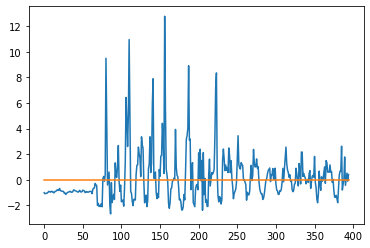

In [256]:
import math
import numpy as np

leftList = (np.array(leftGolbanAngleList) + np.array(leftLegAngleList))
rightList = (np.array(rightGolbanAngleList) + np.array(rightLegAngleList))
GLList = 3 * ((leftList / rightList)-1)

import matplotlib.pyplot as plt

start = 0
end = len(GLList)
y = range(start, end)
plt.plot(y, np.array(GLList)[start:end])
plt.plot(y, np.zeros_like(np.array(GLList)[start:end]))
plt.show()

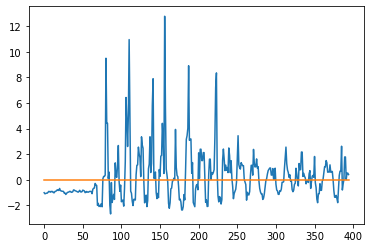

In [257]:
List = []
for i in range(len(GLList)-1):
    if i!=0:
        if (GLList[i-1] * GLList[i]) < 0 and (GLList[i] * GLList[i+1]) < 0:
            diff = GLList[i-1] - GLList[i]
            GLList[i] += diff
        
start = 0
end = len(GLList)
y = range(start, end)
plt.plot(y, np.array(GLList)[start:end])
plt.plot(y, np.zeros_like(np.array(GLList)[start:end]))
plt.show()

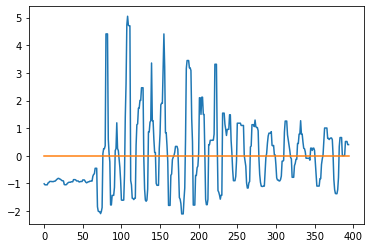

In [258]:
from scipy.signal import medfilt

GLList = medfilt(GLList, kernel_size=5)

import matplotlib.pyplot as plt

start = 0
end = len(GLList)
y = range(start, end)
plt.plot(y, np.array(GLList)[start:end])
plt.plot(y, np.zeros_like(np.array(GLList)[start:end]))
plt.show()

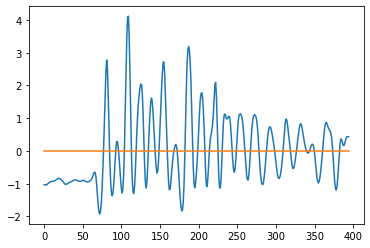

In [259]:
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter1d

GLList = gaussian_filter1d(GLList, sigma=1.8)

import matplotlib.pyplot as plt

start = 0
end = len(GLList)
y = range(start, end)
plt.plot(y, np.array(GLList)[start:end])
plt.plot(y, np.zeros_like(np.array(GLList)[start:end]))
plt.show()

In [260]:
cnt = -1
onSwing = 0

for i in range(len(GLList)-1):
    if(GLList[i]*GLList[i+1] < 0):
        cnt += 1
    else:
        onSwing += 1

In [262]:
print("총 횟수:",cnt)

총 횟수: 36
